<a href="https://colab.research.google.com/github/utility001/cifar-10/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big picture

Practice training a deep neural network on the CIFAR10 image dataset:

a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function.

b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with tf.keras.datasets.cifar10.load_data().
The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons.
Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

c. Now try adding batch normalization and compare the learning curves: is it converging faster than before? Does it produce a bettermodel? How does it affect training speed?

d. Try replacing batch normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout.

f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

# Ingest

In [2]:
!pip install --upgrade tensorflow

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pandas as pd

In [4]:
# cifar_10 details
tf.keras.datasets.cifar10.load_data?

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    random_state=42,
    test_size=10_000,
    shuffle=True,
    stratify=y_train_full
)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [9]:
y_train.shape, y_val.shape, y_test.shape

((40000, 1), (10000, 1), (10000, 1))

In [10]:
X_train[0].shape, X_train[0].min(), X_train[0].max()

((32, 32, 3), 0, 217)

In [11]:
X_train.min(), X_train.max()

(0, 255)

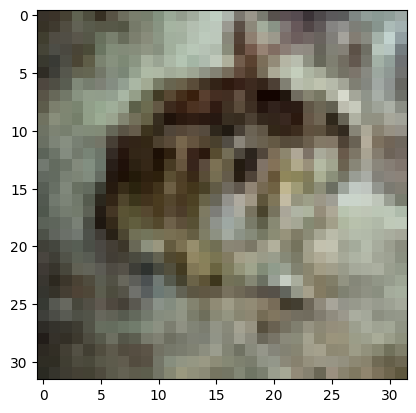

In [12]:
plt.imshow(X_train[0], interpolation='nearest')

In [13]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels[y_train.flatten()[0]]

'frog'

In [14]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
y_test[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], dtype=uint8)

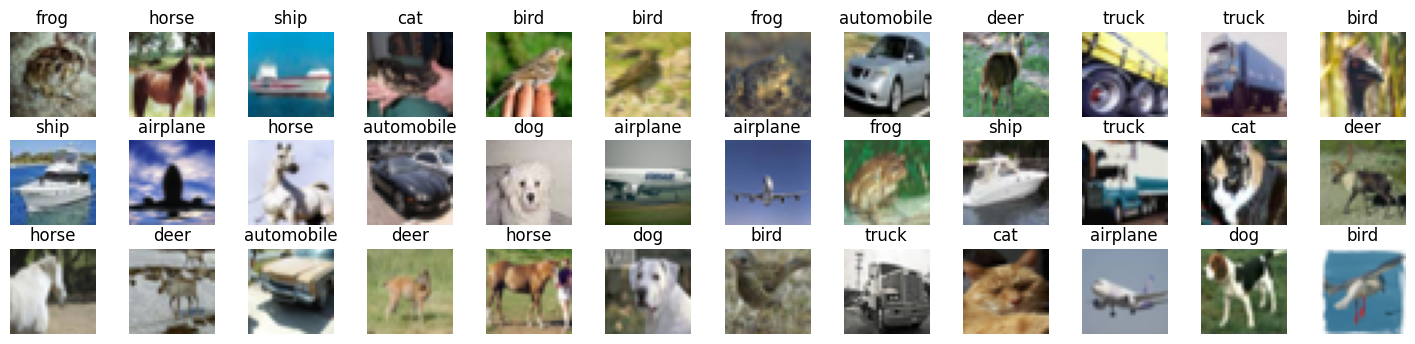

In [15]:
#  Plot a few images from the dataset
plt.figure(figsize=(18, 4))
for idx, image_data in enumerate(X_train[:36]):
    plt.subplot(3, 12, idx + 1)
    plt.imshow(X_train[idx], cmap="binary")
    plt.axis("off");
    plt.title(labels[y_train[idx]])
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show();

In [16]:
def get_value_counts(target, name):
    value_counts = pd.Series(target, name=name).value_counts()
    percentages = (value_counts/len(target)) * 100

    vcs = pd.DataFrame({
        f"{name} counts": value_counts,
        f"{name} %": percentages
    })
    return vcs

In [17]:
ytr = get_value_counts(y_train, name="y_train")
yva = get_value_counts(y_val, name="y_val")
yte = get_value_counts(y_test, name='y_test|')
pd.concat([ytr, yva, yte], axis=1, keys=['train', 'validation', 'test']).sort_index()

train             validation                   test          
  y_train counts y_train % y_val counts y_val % y_test| counts y_test| %
0           4000      10.0         1000    10.0           1000      10.0
1           4000      10.0         1000    10.0           1000      10.0
2           4000      10.0         1000    10.0           1000      10.0
3           4000      10.0         1000    10.0           1000      10.0
4           4000      10.0         1000    10.0           1000      10.0
5           4000      10.0         1000    10.0           1000      10.0
6           4000      10.0         1000    10.0           1000      10.0
7           4000      10.0         1000    10.0           1000      10.0
8           4000      10.0         1000    10.0           1000      10.0
9           4000      10.0         1000    10.0           1000      10.0

Obs: Well stratified

### Task 1

 Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the swish activation function.

In [18]:
input_shape = X_train[0].shape
input_shape

(32, 32, 3)

In [19]:
tf.keras.layers.InputLayer?

In [22]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# initializer
he_uniform = tf.keras.initializers.he_uniform()

# activation
swish = tf.keras.activations.swish

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=input_shape)
    ])

for layers in range(20):
    model.add(tf.keras.layers.Dense(
        units = 100,
        activation=swish,
        kernel_initializer=he_uniform))
model.add(tf.keras.layers.Dense(
    units=10,
    activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32, 32, 100)         │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32, 32, 100)         │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32, 32, 10)          │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 193,310 (755.12 KB)

 Trainable params: 193,310 (755.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
metrics = tf.keras.metrics.sparse_categorical_accuracy

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
def counts(target, name):
    value_counts = pd.Series(target, name=name).value_counts()
    percentages = (value_counts/len(target)) * 100

    vcs = pd.DataFrame({
        f"count {name}": value_counts,
        f"percentages {name}": percentages
    })
    return vcs